# OCIP - Similarity Matching Sandbox

### Purpose

Created by: Techmien Corp. / Carlos E. Paz-Soldan / 2025-02-15

This Jupyter Notebook is designed to test similarity matching between business innovation challenges and research facilities.
It uses Azure OpenAI for text summarization and embedding generation, compares them using cosine similarty, and uses K-Means clustering and PCA for visualization.


### PREPARE ENVIRONMENT AND DEFINE FUNCTIONS

In [1]:
# PREPARE ENVIRONMENT 
import openai
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tiktoken # to count tokens in text
#import ace_tools as tools  # For displaying the table in Jupyter Notebook

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from IPython.display import display

# Ensure openpyxl is installed for reading Excel files
try:
    import openpyxl
except ImportError:
    print("Missing optional dependency 'openpyxl'. Install it using: pip install openpyxl")
    raise

# AZURE OpenAI CREDENTIALS
openai.api_type = "azure"
openai.api_base = "https://carlo-m6va7ncq-eastus.cognitiveservices.azure.com/"      # Our Azure OpenAI endpoint
openai.api_version = "2023-07-01-preview"
openai.api_key = "932O2kcHZsfISi0W7bbXzVO7P0iKWVX5lxlDz6lFmqL1mbHrRZ7sJQQJ99BBACYeBjFXJ3w3AAAAACOGveuB"  # Our Azure OpenAI API keysummarizer_model

# AZURE AI FOUNDRY DEPLOYMENTS
summarizer_model = "gpt-35-turbo-instruct_depl"     # Deployment name for our summarization model
#summarizer_model = "gpt-o1-depl"                    # Deployment name for our summarization model

#embedding_model = "text-embedding-3-small_depl"    # Deployment name for our Embedding model (trying with -small or - large)
embedding_model = "text-embedding-3-large_depl"     # Deployment name for our Embedding model (trying with -small or - large)

# Function to call Azure OpenAI API with error handling
def call_openai_api(call_function, max_retries=3, wait_time=2):
    """Retries API calls with exponential backoff."""
    for attempt in range(max_retries):
        try:
            return call_function()
        except openai.error.RateLimitError:
            print(f"Rate limit reached. Retrying in {wait_time} seconds...")
        except openai.error.APIError as e:
            print(f"API error: {e}. Retrying in {wait_time} seconds...")
        except openai.error.Timeout:
            print(f"Request timed out. Retrying in {wait_time} seconds...")
        except openai.error.InvalidRequestError as e:
            print(f"Invalid request: {e}. Check model name and input format.")
            break  # Stop retrying for invalid requests
        except openai.error.AuthenticationError:
            print("Authentication error. Check your API key.")
            break
        except openai.error.ServiceUnavailableError:
            print(f"Service unavailable. Retrying in {wait_time} seconds...")
        except Exception as e:
            print(f"Unexpected error: {e}. Retrying in {wait_time} seconds...")
        
        time.sleep(wait_time)
        wait_time *= 2  # Exponential backoff
    return None  # Return None if all retries fail

### CONFIGURE API CALLS

In [12]:
# Function to summarize Challenge info                                         - ENTER CHALLENGE SUMMARIZATION PROMPT & PARAMETERS
def summarize_challenge_text(model_deployment, text):    
    return call_openai_api(lambda: openai.Completion.create(
        engine=model_deployment,
        prompt=f"List the key research capabilities required for this innovation challenge in bullet points (each point should be 5 words or fewer).\n\n{text}\n\nSummary:",
        max_tokens=100,
        temperature=0.25
    )["choices"][0]["text"].strip())

# Function to summarize Facility info                                         - ENTER FACILITIES SUMMARIZATION PROMPT & PARAMETERS
def summarize_facility_text(model_deployment, text):    
    return call_openai_api(lambda: openai.Completion.create(
        engine=model_deployment,
#        prompt=f"List the key research capabilities of this facility in bullet points (each point should be 5 words or fewer):\n\n{text}\n\nSummary:",
        prompt=f"List the key research capabilities of the facility described below, focusing on how they could help businesses address an innovation challenge. Do not cut-off your summary, but ignore repetitive text and marketing verbiage, and provide answer in concise bullet points:\n\n{text}\n\nSummary:",
        max_tokens = 125,
        temperature= 0.25
    )["choices"][0]["text"].strip())

# Function to get embeddings
def get_embedding(text):    
    return call_openai_api(lambda: openai.Embedding.create(
        input=text,
        engine=embedding_model
    )["data"][0]["embedding"])

### LOAD DATA FILES

In [3]:
# Load research Facility data from Excel file to Pandas dataframe
excel_file_path = ".\data\ocip-sandbox-data.xlsx"       # Update with the actual file path
sheet_name = "Facilities"                               # Update with the actual sheet name if needed
df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
# Filter rows where 'Status' column is 'Active' or 'Enabled'
dff = df[df['Status'].isin(["Active", "Enabled"])]
#display(dff)        # Display the table of Facilities

# Load Innovation Challenge data from Excel file to Pandas dataframe
excel_file_path = ".\data\ocip-sandbox-data.xlsx"       # Update with the actual file path
sheet_name = "InnovationChallenges"                     # Update with the actual sheet name if needed
df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
# Filter rows where 'Status' column is 'Active' or 'Enabled'
dfc = df[~df['Status'].isin(["Abandoned", "Rejected"])]
# Display the table
#display(dfc)        # Display the table of Challenges

data_loaded = True

### TEST SUMMARIZATION - SINGLE FACILITY

In [5]:
# SUMMARIZE A SINGLE FACILITY
# Select a Facility row                             # ROW 0 SKIPS THIS SECTION
facility_row = 5
#facility_row = int(input("ENTER FACILITY ROW#"))   # Ensures input is an integer

if facility_row != 0:
    facility = ""
    #facility +=        str(dff.iloc[facility_row]['HeiName'])
    #facility += " | "+ str(dff.iloc[facility_row]['ParentAU'])
    #facility += " | "+ dff.iloc[facility_row]['FacilityName']
    facility +=         str(dff.iloc[facility_row]['FacilityFullName'])
    facility += " | "+  str(dff.iloc[facility_row]['Description'])
    # Print to verify
    print("Facility", facility_row, " (", len(facility.split()),"words):\n", dff.iloc[facility_row]['HeiName'], " | ", facility)

    # Summarize the Facility capabilities
    facility_summary = dff.iloc[facility_row]['FacilityName'] + "\n" + summarize_facility_text(summarizer_model, facility)
    # Choose a tokenizer model (use 'cl100k_base' for GPT-4, GPT-3.5)
    tokenizer = tiktoken.get_encoding("cl100k_base")
    print ("\nSummary: (",len(facility_summary.split()),"words,",len(tokenizer.encode(facility_summary)), "tokens)\n", facility_summary)

Facility 5  ( 40 words):
 Algonquin College  |   | Human-Centred Design Lab | HCDL is focused on developing evidence-based design strategies that address complex human-centered problems. We also want to help our partners implement, improve, and commercialize their products, services, and systems by examining and implementing emerging technologies.

Summary: ( 76 words, 105 tokens)
 Human-Centred Design Lab
- Conducting research on human-centered design strategies
- Developing evidence-based solutions for complex human-centered problems
- Implementing and improving products, services, and systems
- Examining and implementing emerging technologies
- Providing evidence-based design recommendations for businesses
- Offering support in commercializing products, services, and systems
- Conducting research on emerging technologies and their potential impact on businesses
- Collaborating with businesses to address specific innovation challenges
- Utilizing a user-centric approach to problem-so

### TEST SUMMARIZATION - SINGLE CHALLENGE

In [11]:
# SUMMARIZE A SINGLE CHALLENGE
# Select a Challenge row                             # ROW 0 SKIPS THIS SECTION
challenge_row = 6
#challenge_row = int(input("ENTER CHALLENGE ROW#"))  # Ensures input is an integer

if challenge_row != 0:
    challenge = ""
    challenge +=        str(dfc.iloc[challenge_row]['InnovationChallengeName'])
    challenge += " | "+ str(dfc.iloc[challenge_row]['IndustrialSector'])
    challenge += " | "+ str(dfc.iloc[challenge_row]['Description'])
    challenge += " | "+ str(dfc.iloc[challenge_row]['WhatIsInScope'])
    challenge += " | "+ str(dfc.iloc[challenge_row]['SoWMandatoryDeliverables'])
    challenge += " | "+  str(dfc.iloc[challenge_row]['SoWActivities'])
    challenge += " | "+  str(dfc.iloc[challenge_row]['SoWExpertise'])
    # Print to verify
    print("Challenge", challenge_row, " (", len(challenge.split()),"words):", dfc.iloc[challenge_row]['InnovationChallengeName'],"(Status:", dfc.iloc[challenge_row]['Status'],")\n", challenge)

    # Summarize the Challenge capabilities
    challenge_summary = dfc.iloc[challenge_row]['InnovationChallengeName'] + "\n" + summarize_challenge_text(summarizer_model, challenge)
    # Choose a tokenizer model (use 'cl100k_base' for GPT-4, GPT-3.5)
    tokenizer = tiktoken.get_encoding("cl100k_base")
    print ("\nSummary: (",len(challenge_summary.split()),"words,",len(tokenizer.encode(challenge_summary)), "tokens)\n", challenge_summary)

Challenge 6  ( 362 words): AI-Assisted Support for Teachers - Learning and Assessment Design (Status: ProjectProposalAccepted )
 AI-Assisted Support for Teachers - Learning and Assessment Design | 51.3.2.11 - Information and cultural industries / Publishing industries / Software publishers / Software publishers (except video game publishers) | Gibbly testing thus far has indicated that teachers feel a shortage of time in the classroom, and need support with maximizing the time they have with their students. The challenge: Research & discover how we might [1] more extensively understand their needs in the classroom as they pertain to time, and [2] best address those needs by leveraging AI and education technology (edtech) tools for learning and assessment through the Gibbly platform. Gibbly may then continue to refine their platform and grow their user base. | Define a more precise research scope and question Develop a methodology and select the best methods for conducting the inquiry a

### BULK SUMMARIZE FACILITIES **VERY EXPENSIVE OPERATION!**
(For 845 Facilities: 11 minutes to summarize)
OR IMPORT PREVIOUS XLSX

In [ ]:
input("**ARE YOU SURE YOU WANT TO CONTINUE?**")     # Confirm
# Summarize each Facility in the dff dataframe
dff['FacilityInfo'] = dff.apply(lambda row: f"{row['FacilityFullName']} | {row['Description']}", axis=1)
print("Summarizing...", len(dff), "Facilities")
dff['FacilitySummary'] = dff.apply(lambda row: f"{row['FacilityName']}\n{summarize_facility_text(summarizer_model, row['FacilityInfo'])}", axis=1)

# Save the expanded dataframe as a new Excel file
output_file_path = "./data/ocip-facility-summaries.xlsx"
dff.to_excel(output_file_path, index=False)
print(f"Expanded dataframe saved to {output_file_path}")

In [15]:
# ALTERNATIVE: IMPORT dff dataframe from Excel file
input("**ARE YOU SURE YOU WANT TO IMPORT?**")     # Confirm
# Load the expanded dataframe from a previously saved Excel file
input_file_path = "./data/ocip-facility-summaries.xlsx"
dff = pd.read_excel(input_file_path)
print(f"Summaries dataframe loaded from {input_file_path}")

Summaries dataframe loaded from ./data/ocip-facility-summaries.xlsx


### BULK EMBED ALL FACILITIES **EXPENSIVE OPERATION**
(For 845 Facilities: 94 seconds to embed)

In [52]:
# Generate embeddings for  each Facility in the dff dataframe
print("Embedding...", len(dff), "Facilities")
#dff['FacilityEmbedding'] = dff['FacilitySummary'].apply(lambda summary: json.dumps(get_embedding(summary)))

# Save the expanded dataframe as a new CSV file
output_file_path = "./data/ocip-facility-embeddings.csv"
dff.to_csv(output_file_path, index=False)
print(f"Expanded dataframe saved to {output_file_path}")

Embedding... 845 Facilities
Expanded dataframe saved to ./data/ocip-facility-embeddings.csv


In [16]:
# ALTERNATIVE: IMPORT dff dataframe from CSV file
input("**ARE YOU SURE YOU WANT TO IMPORT?**")     # Confirm
# Load the expanded dataframe from a previously saved Excel file
input_file_path = "./data/ocip-facility-embeddings.csv"
dff = pd.read_csv(input_file_path)
print(f"Embeddings dataframe loaded from {input_file_path}")

Embeddings dataframe loaded from ./data/ocip-facility-embeddings.csv


### RECOMMEND FACILITIES FOR A CHALLENGE
(Takes ~90 seconds)

In [17]:
# Select a Challenge row
challenge_row = 6
#challenge_row = int(input("ENTER CHALLENGE ROW#"))  # Ensures input is an integer
challenge = ""
challenge +=        str(dfc.iloc[challenge_row]['InnovationChallengeName'])
challenge += " | "+ str(dfc.iloc[challenge_row]['IndustrialSector'])
challenge += " | "+ str(dfc.iloc[challenge_row]['Description'])
challenge += " | "+ str(dfc.iloc[challenge_row]['WhatIsInScope'])
challenge += " | "+ str(dfc.iloc[challenge_row]['SoWMandatoryDeliverables'])
challenge += " | "+  str(dfc.iloc[challenge_row]['SoWActivities'])
challenge += " | "+  str(dfc.iloc[challenge_row]['SoWExpertise'])
# Print to verify
print("Challenge", challenge_row, " (", len(challenge.split()),"words):", dfc.iloc[challenge_row]['InnovationChallengeName'],"(Status:", dfc.iloc[challenge_row]['Status'],")\n", challenge)

# Summarize the Challenge capabilities
challenge_summary = dfc.iloc[challenge_row]['InnovationChallengeName'] + "\n" + summarize_challenge_text(summarizer_model, challenge)
# Choose a tokenizer model (use 'cl100k_base' for GPT-4, GPT-3.5)
tokenizer = tiktoken.get_encoding("cl100k_base")
print ("Summary: (",len(challenge_summary.split()),"words,",len(tokenizer.encode(challenge_summary)), "tokens)\n", challenge_summary)

# Generate embeddings for the Challenge summary
challenge_embedding = get_embedding(challenge_summary)

# Calculate cosine similarity of the Challenge embedding against each of the Facilities in dff
facility_embeddings = dff['FacilityEmbedding'].apply(json.loads).tolist()
similarity_scores = [cosine_similarity([challenge_embedding], [facility_embedding])[0][0] for facility_embedding in facility_embeddings]

# Generate a results table that contains each FacilityName, Similarity score, and FacilitySummary
scores_df = pd.DataFrame({
    "FacilityName": dff['FacilityName'],    
    "SimilarityScore": similarity_scores,
    "FacilitySummary": dff['FacilitySummary']
})

# Define & apply categories based on the similarity score ranges
def categorize_score(score):
    if score == 1.0:
        return "Perfect Match!"
    elif 0.8 <= score < 1.0:
        return "Strong Similarity"
    elif 0.5 <= score < 0.8:
        return "Moderate Similarity"
    elif 0.2 <= score < 0.5:
        return "Weak Similarity"
    else:
        return "Very Weak Similarity"
scores_df["ScoreCategory"] = scores_df["SimilarityScore"].apply(categorize_score)

# Sort the table in descending order by Similarity score
scores_df = scores_df.sort_values(by="SimilarityScore", ascending=False)
print("\nMax Score:", max(similarity_scores), " | Min Score:", min(similarity_scores))
display(scores_df)

# Save the table to an Excel file called "ScoringFor_{InnovationChallengeId}.xlsx"
output_file_path = f"./data/ScoringFor_{dfc.iloc[challenge_row]['InnovationChallengeId']}.xlsx"
scores_df.to_excel(output_file_path, index=False)
print(f"Results saved to {output_file_path}")

Challenge 6  ( 362 words): AI-Assisted Support for Teachers - Learning and Assessment Design (Status: ProjectProposalAccepted )
 AI-Assisted Support for Teachers - Learning and Assessment Design | 51.3.2.11 - Information and cultural industries / Publishing industries / Software publishers / Software publishers (except video game publishers) | Gibbly testing thus far has indicated that teachers feel a shortage of time in the classroom, and need support with maximizing the time they have with their students. The challenge: Research & discover how we might [1] more extensively understand their needs in the classroom as they pertain to time, and [2] best address those needs by leveraging AI and education technology (edtech) tools for learning and assessment through the Gibbly platform. Gibbly may then continue to refine their platform and grow their user base. | Define a more precise research scope and question Develop a methodology and select the best methods for conducting the inquiry a

,FacilityName,SimilarityScore,FacilitySummary,ScoreCategory
350,Ingenuity Labs Research Institute,0.470473,Ingenuity Labs Research Institute\n- Research ...,Weak Similarity
337,Adaptive Context Environments Lab,0.464584,Adaptive Context Environments Lab\n- Focus on ...,Weak Similarity
425,Ambient Intelligence and Interactive Machines ...,0.464058,Ambient Intelligence and Interactive Machines ...,Weak Similarity
5,Human-Centred Design Lab,0.463419,Human-Centred Design Lab\n- Conducting researc...,Weak Similarity
72,The AI Hub,0.450360,The AI Hub\n- Access to technical expertise in...,Weak Similarity
...,...,...,...,...
34,Plasma Spray Coating Facility,0.171642,Plasma Spray Coating Facility\n- Air plasma sp...,Very Weak Similarity
327,Necropsy Facility Haileybury,0.170489,Necropsy Facility Haileybury\n,Very Weak Similarity
694,Flow Cytometry and Virometry Core Facility,0.168449,Flow Cytometry and Virometry Core Facility\n- ...,Very Weak Similarity
707,Centre for the Neurobiology of Stress,0.164736,Centre for the Neurobiology of Stress\n- $10-m...,Very Weak Similarity


Results saved to ./data/ScoringFor_15a1f1fd-17c2-43ea-ab8e-5d229bc122f2.xlsx


### VISUALIZE  RESULTS

In [15]:
display(scores_df)

,FacilityName,SimilarityScore,FacilitySummary,ScoreCategory
350,Ingenuity Labs Research Institute,0.472332,Ingenuity Labs Research Institute\n- Research ...,Weak Similarity
425,Ambient Intelligence and Interactive Machines ...,0.466078,Ambient Intelligence and Interactive Machines ...,Weak Similarity
5,Human-Centred Design Lab,0.464859,Human-Centred Design Lab\n- Conducting researc...,Weak Similarity
337,Adaptive Context Environments Lab,0.464501,Adaptive Context Environments Lab\n- Focus on ...,Weak Similarity
72,The AI Hub,0.455838,The AI Hub\n- Access to technical expertise in...,Weak Similarity
...,...,...,...,...
34,Plasma Spray Coating Facility,0.174287,Plasma Spray Coating Facility\n- Air plasma sp...,Very Weak Similarity
694,Flow Cytometry and Virometry Core Facility,0.171029,Flow Cytometry and Virometry Core Facility\n- ...,Very Weak Similarity
327,Necropsy Facility Haileybury,0.170000,Necropsy Facility Haileybury\n,Very Weak Similarity
707,Centre for the Neurobiology of Stress,0.162518,Centre for the Neurobiology of Stress\n- $10-m...,Very Weak Similarity


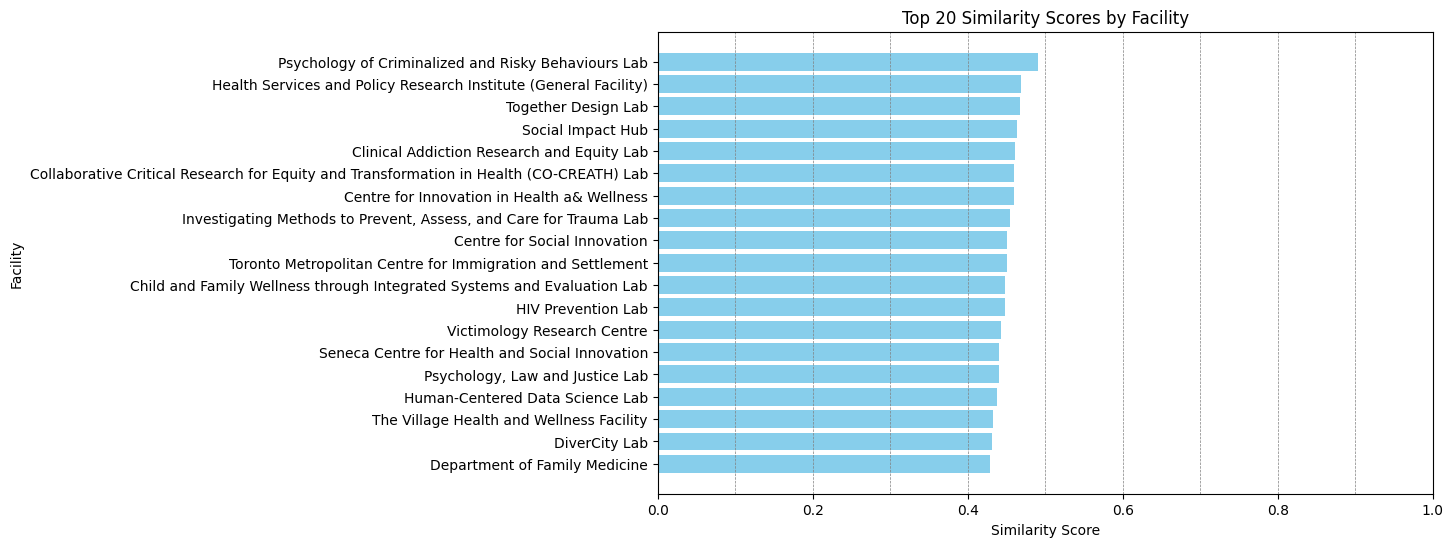

In [8]:
# --- BAR CHART VISUALIZATION ---
top_n = 20
top_n_scores_df = scores_df.sort_values(by="SimilarityScore", ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_scores_df["FacilityName"], top_n_scores_df["SimilarityScore"], color='skyblue')
plt.xlabel("Similarity Score")
plt.ylabel("Facility")
plt.title(f"Top {top_n} Similarity Scores by Facility")
plt.xlim(0, 1)  # Ensure scores are between 0 and 1
plt.gca().invert_yaxis()  # Highest score at the top
for x in np.arange(0.1, 1.1, 0.1):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)

plt.show()

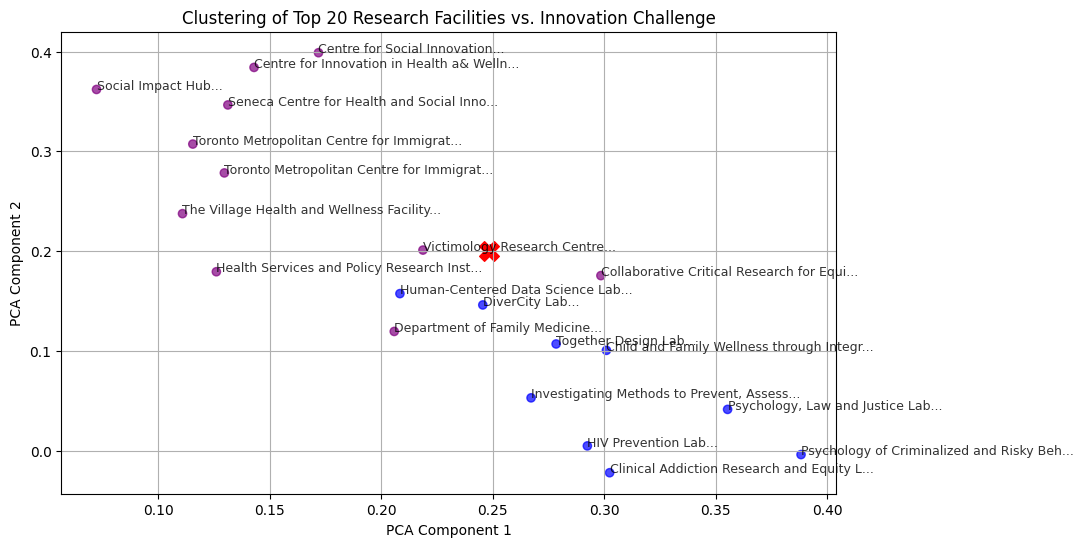

In [9]:
# CLUSTERING PCA VISUALIZATION
# top_n = the number of top Facilities to plot is defined in previous step
# Perform clustering using K-Means algorithm
num_clusters = 3    # Number of clusters to create
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(facility_embeddings)

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(np.vstack([challenge_embedding, facility_embeddings]))

# Split reduced embeddings
challenge_reduced = reduced_embeddings[0]
facility_reduced = reduced_embeddings[1:]

# Filter top N facilities
top_n_indices = top_n_scores_df.index[:top_n]
top_n_facility_reduced = facility_reduced[top_n_indices]

# Define colours for clusters
colors = ['blue', 'green', 'purple']
cluster_colors = [colors[label] for label in cluster_labels[top_n_indices]]

# Plot the embeddings with clusters
plt.figure(figsize=(10, 6))

# Manually plot each cluster to ensure they appear in the legend
for i, color in enumerate(colors):
    plt.scatter([], [], color=color, label=f"Cluster {i}")

# Plot the actual points
plt.scatter(top_n_facility_reduced[:, 0], top_n_facility_reduced[:, 1], c=cluster_colors, alpha=0.7)

# Ensure the innovation challenge point is correctly labeled
plt.scatter(challenge_reduced[0], challenge_reduced[1], color="red", marker="X", s=200, label="Innovation Challenge")

# Add Annotations
for i, label in enumerate(top_n_scores_df['FacilityName'][:top_n]):
    plt.annotate(label[:40] + "...", (top_n_facility_reduced[i, 0], top_n_facility_reduced[i, 1]), fontsize=9, alpha=0.8)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Clustering of Top {top_n} Research Facilities vs. Innovation Challenge")
#plt.legend(loc="lower center")
plt.grid(True)
plt.show()


### Post-execution


In [ ]:
print("ALL DONE")

DONE
